# 06 - Vectorized: A fast QAOA simulator for prototyping

This notebook introduces and provides some simple benchmarks (against `qiskit.AerSimulator('statevector')`) to demonstrate the ability to simulate relatively modest QAOA circuits fast.

## Begin by importing necessary modules

In [1]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

#importing the time module to record time for simulations
from time import time

## Step 1: Create a problem instance
We begin by creating a problem instance for a simple MaximumCut problem for a random graph created using the python `networkx` module. MaximumCut is a go-to problem to demonstrate QAOA in action.

For this, we first:
- create a random graph using the `networkx` module
- using the MaximumCut problem class, we translate into the QUBO formalism to optimize with QAOA

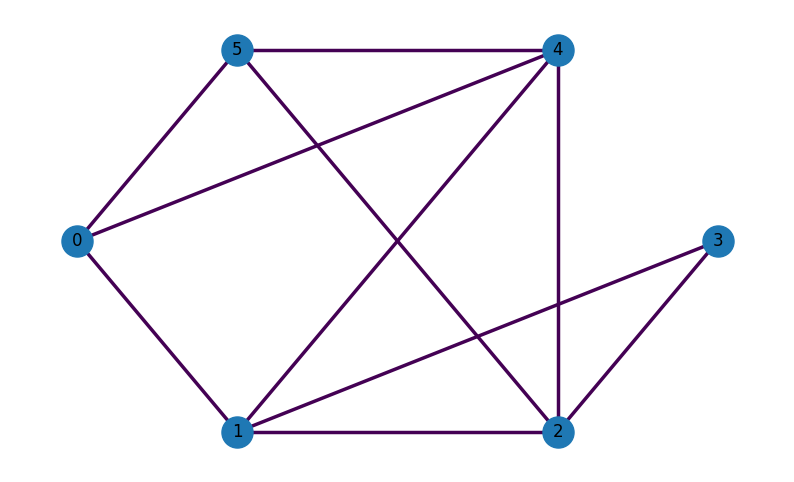

In [2]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability, seed=12)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [3]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The property `qubo` translates the problem into a binary Qubo problem. 
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.qubo

In [4]:
pprint(maxcut_qubo.asdict())

{'constant': 0,
 'metadata': {},
 'n': 6,
 'problem_instance': {'G': {'directed': False,
                            'graph': {},
                            'links': [{'source': 0, 'target': 1},
                                      {'source': 0, 'target': 4},
                                      {'source': 0, 'target': 5},
                                      {'source': 1, 'target': 2},
                                      {'source': 1, 'target': 3},
                                      {'source': 1, 'target': 4},
                                      {'source': 2, 'target': 3},
                                      {'source': 2, 'target': 4},
                                      {'source': 2, 'target': 5},
                                      {'source': 4, 'target': 5}],
                            'multigraph': False,
                            'nodes': [{'id': 0},
                                      {'id': 1},
                                      {'id': 2},
             

#### Extract the exact solution for a small enough problem



In [5]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -4.0, Solution: ['101000', '111000', '101100', '101010', '100110', '101110', '010001', '011001', '010101', '010011', '000111', '010111']


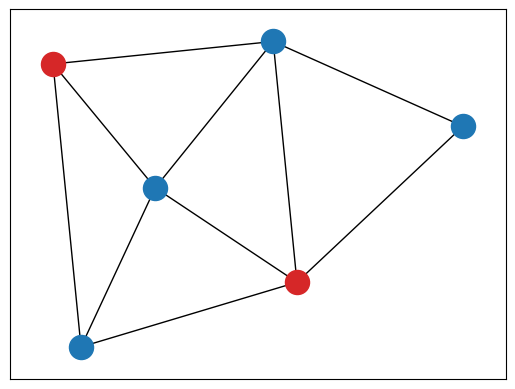

In [6]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

## Step 2: Build the QAOA model
We will build two different models with the same exact configurations except the device used. To compare the performance of `vectorized` backend to that of `qiskit.statevector_simulator`.

In [7]:
q_qiskit_list = []
q_vector_list = []

for p in range(1,10):

    ## QAOA with Qiskit Simulator
    # initialize model with default configuration
    q_qiskit = QAOA()

    # optionally configure the following properties of the model

    # device
    qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
    q_qiskit.set_device(qiskit_device)

    # circuit properties
    q_qiskit.set_circuit_properties(p=p, param_type='standard', init_type='rand', mixer_hamiltonian='x', seed=12)

    # backend properties (already set by default)
    q_qiskit.set_backend_properties(prepend_state=None, append_state=None)

    # classical optimizer properties
    q_qiskit.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                                        optimization_progress=True, cost_progress=True, parameter_log=True)

    q_qiskit_list.append(q_qiskit)


    ## QAOA with Vectorized Simulator
    # initialize model with default configuration
    q_vector = QAOA()

    # optionally configure the following properties of the model

    # device
    vectorized_device = create_device(location='local', name='vectorized')
    q_vector.set_device(vectorized_device)

    # circuit properties
    q_vector.set_circuit_properties(p=p, param_type='standard', init_type='rand', mixer_hamiltonian='x', seed=12)

    # backend properties (already set by default)
    q_vector.set_backend_properties(prepend_state=None, append_state=None)

    # classical optimizer properties
    q_vector.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                            optimization_progress=True, cost_progress=True, parameter_log=True)

    q_vector_list.append(q_vector)


## Step 3: Compile and Optimize

- Once the QAOA model is configured, we need to compile it. **Compilation is necessary** because the QAOA solver has to interact with the problem in to be able to create the underlying QAOA circuit.
- The problem is ready to be optimized now. The user can call `model.optimize()` to initiate the optimization loop. 

Since the purpose of this notebook is to compare the speed performance of vectorized, we will run the optimization loop and record the time required to finish the optimization. Repeating this step for different depth of circuits is also presented.

In [8]:
times_qiskit = []
times_vectorized = []

for q_qiskit, q_vector in zip(q_qiskit_list, q_vector_list):
    
    q_qiskit.compile(maxcut_qubo,verbose=False) 
    q_vector.compile(maxcut_qubo,verbose=False) 
    
    t1=time()
    q_qiskit.optimize()
    
    t2=time()

    q_vector.optimize()
    t3=time()
    
    times_qiskit.append(t2-t1)
    times_vectorized.append(t3-t2)

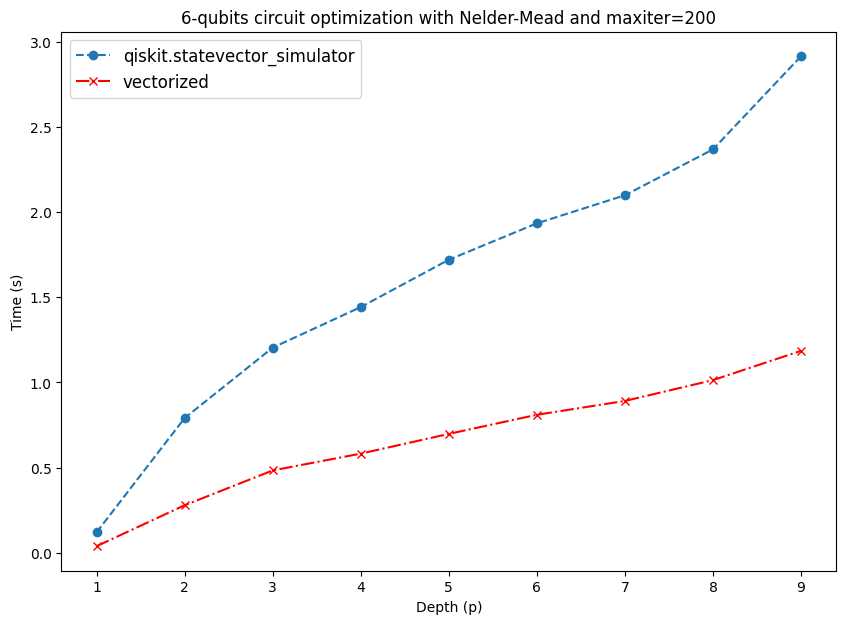

In [9]:
ps = range(1,10)
figure = plt.figure(figsize=(10,7))
plt.plot(ps, times_qiskit, ls = '--', marker = 'o', label='qiskit.statevector_simulator')
plt.plot(ps, times_vectorized, color='red', ls='-.', marker='x', label = 'vectorized')
plt.xlabel('Depth (p)')
plt.ylabel('Time (s)')
plt.title('6-qubits circuit optimization with Nelder-Mead and maxiter=200')
plt.legend(fontsize=12)

## Step 4: Accessing the results

Compare the evolution of cost value for both devices for a sanity check

In [10]:
vector_opt_results = q_vector.result
qiskit_opt_results = q_qiskit.result

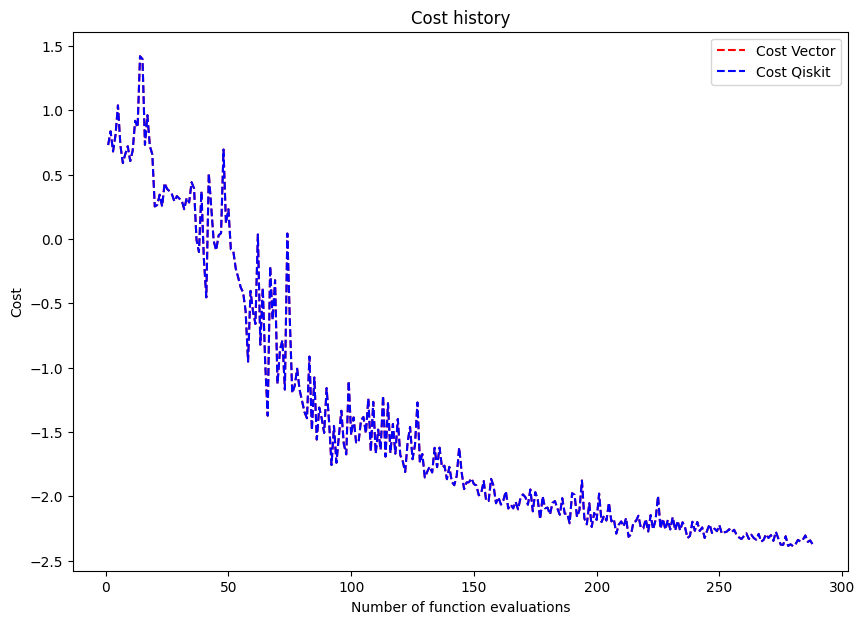

In [11]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
fig, ax = vector_opt_results.plot_cost(label='Cost Vector',color='red',ax=ax)
fig, ax = qiskit_opt_results.plot_cost(label='Cost Qiskit',color='blue',ax=ax)

The two cost histories show a complete match between the two devices